In [1]:
import sys
sys.path.append("..")
from blog_tools import data, interact

import scprep
import numpy as np

In [15]:
import ipywidgets as widgets
import plotly.plotly as py
import plotly.graph_objs as go

def plotly_heatmap(data, width=500, height=500):
    axis_layout = dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=True,
        ticks='',
        showticklabels=False
    )
    fig_data = [dict(
        x=np.arange(len(d)),
        y=np.ones_like(d)*i,
        z=d,
        type='heatmap',
        colorscale='Viridis',
        opacity=0.5,
        showscale=i==0,
        zmin=np.min(data),
        zmax=np.max(data)
    ) for i, d in enumerate(data)]
    fig = go.FigureWidget(data=fig_data,
                   layout=go.Layout(
                        xaxis=axis_layout,
                        yaxis=axis_layout,
                        autosize=False,
                        width=width,
                        height=height,
                    ))
    fig.layout.titlefont.size
    fig.layout.titlefont.size = 22
    fig.layout.titlefont.family = 'Rockwell'
    fig.layout.xaxis.title = ''
    fig.layout.yaxis.title = ''

    heatmap = fig.data
    fig.layout.hovermode = 'closest'
    return fig, heatmap

In [39]:
def interactive_heatmap(dataset, heatmap_data, scatter_data=None, scatter_c=None):
    if scatter_data is None:
        scatter_data = dataset.X_true
    if scatter_c is None:
        scatter_c = dataset.c

    scatter_c = interact.to_hex(scatter_c, scatter_data)
    s = np.repeat(10, scatter_data.shape[0])

    fig_sc, scatter = interact.plotly(scatter_data, c=scatter_c, contour=False)
    fig_hm, heatmap = plotly_heatmap(heatmap_data)

    ind_prev = np.array([-1])
    repeat = [0] + list(range(1, 6)) + list(range(-5, 0))

    def hover_fn(trace, points, state):
        ind = points.point_inds[0]
        color = interact.to_hex(heatmap_data[ind], scatter_data)
        color[ind] = '#FF0000'
        size = s.copy()
        size[ind] = 20
        with fig_sc.batch_update():
            scatter.marker.size = size
            scatter.marker.color = color
        with fig_hm.batch_update():
            if ind_prev[0] >= 0:
                heatmap[ind_prev[0]].opacity = 0.5
                heatmap[ind_prev[0]].x = heatmap[ind_prev[0]].x[:len(heatmap[ind_prev[0]].x)//len(repeat)]
                heatmap[ind_prev[0]].y = heatmap[ind_prev[0]].y[:len(heatmap[ind_prev[0]].y)//len(repeat)]
                heatmap[ind_prev[0]].z = heatmap[ind_prev[0]].z[:len(heatmap[ind_prev[0]].z)//len(repeat)]
            heatmap[ind].opacity = 1
            heatmap[ind].x = np.tile(heatmap[ind].x, len(repeat))
            heatmap[ind].z = np.tile(heatmap[ind].z, len(repeat))
            heatmap[ind].y = np.maximum(0, np.minimum(
                len(heatmap)-1,
                np.tile(heatmap[ind].y, len(repeat)) + np.repeat(repeat, len(heatmap[ind].y))))
        ind_prev[0] = ind

    scatter.on_hover(hover_fn)

    dash = widgets.HBox([fig_sc,
                         fig_hm])
    display(dash)

In [40]:
dataset = data.swissroll(n_samples=200, noise=0.02)
order = np.argsort(dataset.c)
dataset.X, dataset.X_true, dataset.c = dataset.X[order], dataset.X_true[order], dataset.c[order] 

## Data

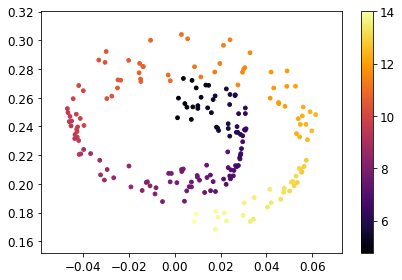

In [41]:
scprep.plot.scatter2d(dataset.X_true, c=dataset.c)

## Distances

In [42]:
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(dataset.X))

In [43]:
interactive_heatmap(dataset, D)

    'data': [{'marker': {'color': array(['#000004', '#000004', '#010106', '#0101…

## Bandwidths

In [26]:
def interactive_heatmap_bandwidth(dataset, heatmap_data, scatter_data=None, scatter_c=None):
    if scatter_data is None:
        scatter_data = dataset.X_true
    if scatter_c is None:
        scatter_c = dataset.c

    scatter_c = interact.to_hex(scatter_c, scatter_data)
    s = np.repeat(10, scatter_data.shape[0])

    fig_sc, scatter = interact.plotly(scatter_data, c=scatter_c, contour=False)
    fig_hm, heatmap = plotly_heatmap(heatmap_data)

    ind_prev = np.array([-1])
    repeat = [0] + list(range(1, 6)) + list(range(-5, 0))

    def hover_fn(trace, points, state):
        ind = points.point_inds[0]
        size = s.copy()
        size[heatmap_data[ind] != 0] = 20
        with fig_sc.batch_update():
            scatter.marker.size = size
        with fig_hm.batch_update():
            if ind_prev[0] >= 0:
                heatmap[ind_prev[0]].opacity = 0.5
                heatmap[ind_prev[0]].x = heatmap[ind_prev[0]].x[:len(heatmap[ind_prev[0]].x)//len(repeat)]
                heatmap[ind_prev[0]].y = heatmap[ind_prev[0]].y[:len(heatmap[ind_prev[0]].y)//len(repeat)]
                heatmap[ind_prev[0]].z = heatmap[ind_prev[0]].z[:len(heatmap[ind_prev[0]].z)//len(repeat)]
            heatmap[ind].opacity = 1
            heatmap[ind].x = np.tile(heatmap[ind].x, len(repeat))
            heatmap[ind].z = np.tile(heatmap[ind].z, len(repeat))
            heatmap[ind].y = np.maximum(0, np.minimum(
                len(heatmap)-1,
                np.tile(heatmap[ind].y, len(repeat)) + np.repeat(repeat, len(heatmap[ind].y))))
        ind_prev[0] = ind

    scatter.on_hover(hover_fn)

    dash = widgets.HBox([fig_sc,
                         fig_hm])
    display(dash)

knn = 5
bandwidth = np.partition(D, knn+1, axis=1)[:,:knn+1].max(axis=1)
D_knn = (D <= bandwidth[:,None]).astype(int)
interactive_heatmap_bandwidth(dataset, D_knn, scatter_c=bandwidth.copy())

    'data': [{'marker': {'color': array(['#f9c72f', '#fa9407', '#f8890c', '#8822…

## Affinities

In [27]:
decay = 15
A = np.exp(-1 * (D / bandwidth[:,None])**decay)
interactive_heatmap(dataset, A)

    'data': [{'marker': {'color': array(['#000004', '#000004', '#010106', '#0101…

## Powered affinities

In [28]:
t = 20
P = A / A.sum(1)[:,None]
Pt = np.linalg.matrix_power(P, t)

In [29]:
interactive_heatmap(dataset, Pt)

    'data': [{'marker': {'color': array(['#000004', '#000004', '#010106', '#0101…

## Potential

In [30]:
potential = -1 * np.log(Pt + 1e-7)

In [31]:
interactive_heatmap(dataset, potential)

    'data': [{'marker': {'color': array(['#000004', '#000004', '#010106', '#0101…

## Potential distance

In [32]:
Dp = squareform(pdist(potential))

In [33]:
interactive_heatmap(dataset, Dp)

    'data': [{'marker': {'color': array(['#000004', '#000004', '#010106', '#0101…

## MDS

In [34]:
import phate
X_cmds = phate.mds.embed_MDS(potential, how='classic')

In [35]:
interactive_heatmap(dataset, Dp, scatter_data=X_cmds)

    'data': [{'marker': {'color': array(['#000004', '#000004', '#010106', '#0101…

In [36]:
X_mmds = phate.mds.embed_MDS(potential, how='metric')

In [37]:
interactive_heatmap(dataset, Dp, scatter_data=X_mmds)

    'data': [{'marker': {'color': array(['#000004', '#000004', '#010106', '#0101…

In [38]:
fig, scatter = interact.plotly(dataset.X_true, c=dataset.c, contour=False)

In [ ]:
scatter.on_